<a href="https://colab.research.google.com/github/noreallyimfine/DS-Unit-2-Regression-Classification/blob/master/module3/Copy_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
   9c51072..8a0d09f  master     -> origin/master
Updating 9c51072..8a0d09f
Fast-forward
 .../assignment_regression_classification_3.ipynb   | 148 +++++++++++++++++++++
 1 file changed, 148 insertions(+)
 create mode 100644 module3/assignment_regression_classification_3.ipy

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [338]:
# Take a look at the data frame

print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011,1,0,1,"10,733",1979,2007,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018,0,6,6,"2,962",15435,1920,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018,0,7,7,"2,074",11332,1930,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014,1,0,1,0,500,0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065,1,0,1,0,6406,0,2,R1,0,01/01/2019


In [314]:
# Null values?
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
# Drop Easement and Apartment number column bec theres too many NaNs
# Easement is entirely NaNs, and Apartment Number isnt very relevant for one family house
df = df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)

In [0]:
df.YEAR_BUILT.fillna(df.YEAR_BUILT.mean(), inplace=True)

In [319]:
df.isna().sum()

BOROUGH                            0
NEIGHBORHOOD                       0
BUILDING_CLASS_CATEGORY            0
TAX_CLASS_AT_PRESENT               1
BLOCK                              0
LOT                                0
BUILDING_CLASS_AT_PRESENT          1
ADDRESS                            0
ZIP_CODE                           1
RESIDENTIAL_UNITS                  1
COMMERCIAL_UNITS                   1
TOTAL_UNITS                        1
LAND_SQUARE_FEET                  53
GROSS_SQUARE_FEET                  1
YEAR_BUILT                         0
TAX_CLASS_AT_TIME_OF_SALE          0
BUILDING_CLASS_AT_TIME_OF_SALE     0
SALE_PRICE                         0
SALE_DATE                          0
dtype: int64

In [237]:
# Do any columns have all the same value, like easement was
df.nunique()

BOROUGH                               5
NEIGHBORHOOD                        252
BUILDING_CLASS_CATEGORY              44
TAX_CLASS_AT_PRESENT                 10
BLOCK                              8044
LOT                                1487
BUILDING_CLASS_AT_PRESENT           146
ADDRESS                           22691
ZIP_CODE                            184
RESIDENTIAL_UNITS                    88
COMMERCIAL_UNITS                     41
TOTAL_UNITS                         102
LAND_SQUARE_FEET                   3652
GROSS_SQUARE_FEET                  3937
YEAR_BUILT                          143
TAX_CLASS_AT_TIME_OF_SALE             3
BUILDING_CLASS_AT_TIME_OF_SALE      147
SALE_PRICE                         3831
SALE_DATE                           120
dtype: int64

In [113]:
# How many One Family Dwellings are in Manhattan?
manhattan = df[df['BOROUGH'] == 1]

manhattan[manhattan['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'].shape

(42, 19)

In [0]:
# How many one family dwellings are there
df['BUILDING_CLASS_CATEGORY'].value_counts()

In [341]:
# Filter dataframe for One Family Dwellings
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

df.shape

(5061, 19)

In [342]:
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [321]:
# Filter for just houses that sold between 100,000 - 2,000,000

df = df[(df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

print(df.shape)
df['SALE_PRICE'].describe()

(3151, 19)


count    3e+03
mean     6e+05
std      3e+05
min      1e+05
25%      4e+05
50%      6e+05
75%      8e+05
max      2e+06
Name: SALE_PRICE, dtype: float64

In [0]:
# Clean out commas and conert to int
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '').astype(int)

In [0]:
df = df[df.LAND_SQUARE_FEET != 0]

In [323]:
# What is the data type of SALE DATE
df['SALE_DATE'].dtypes

dtype('O')

In [344]:
# Make it a datetime object
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

df['SALE_DATE'].dtypes

dtype('<M8[ns]')

In [292]:
# Summary statistics for sale date, looking for date range
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [293]:
# How many values for each month
df['SALE_DATE'].dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: SALE_DATE, dtype: int64

In [345]:
# Make cutoff date and split data on cutoff
cutoff = pd.to_datetime('2019-04-01')

train = df[df['SALE_DATE'] < cutoff]
test =  df[df['SALE_DATE'] >= cutoff]

train.shape, test.shape

((4094, 19), (967, 19))

In [246]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230,1,,1,6800,1325,1930,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427,1,,1,4000,2001,1940,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461,1,,1,3500,2043,1925,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226,1,,1,4000,2680,1899,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203,1,,1,1710,1872,1940,1,A5,620000,2019-01-02


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

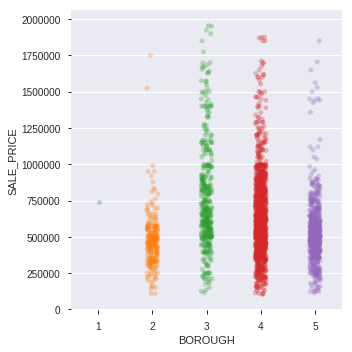

In [217]:
sns.catplot(x='BOROUGH', y='SALE_PRICE', data=train, alpha=0.3);

In [218]:
# Only one data point in Manhattan for train data?
train[train['BOROUGH'] == 1].head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
12816,1,INWOOD,01 ONE FAMILY DWELLINGS,1,2215,369,A9,40 ADRIAN AVENUE,10463,1,,1,938,144,1925,1,A9,739000,2019-03-06


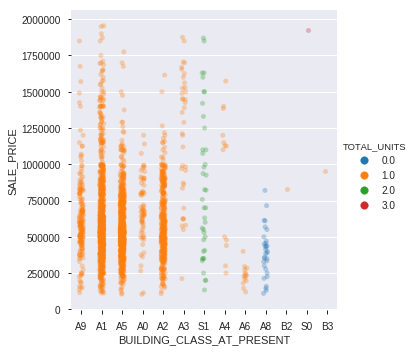

In [219]:
sns.catplot(x='BUILDING_CLASS_AT_PRESENT', y='SALE_PRICE', hue='TOTAL_UNITS', data=train, alpha=0.3)

BOROUGH


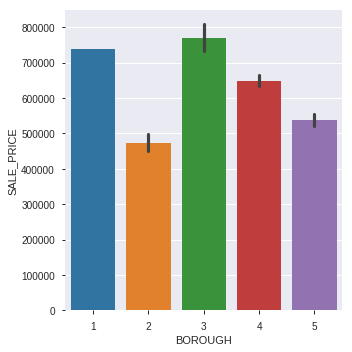

BUILDING_CLASS_AT_PRESENT


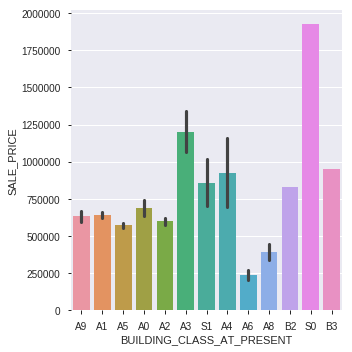

BUILDING_CLASS_AT_TIME_OF_SALE


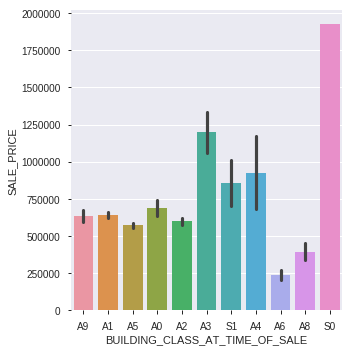

BUILDING_CLASS_CATEGORY


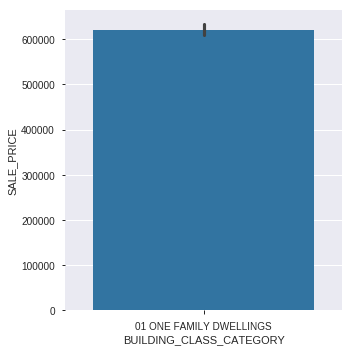

COMMERCIAL_UNITS


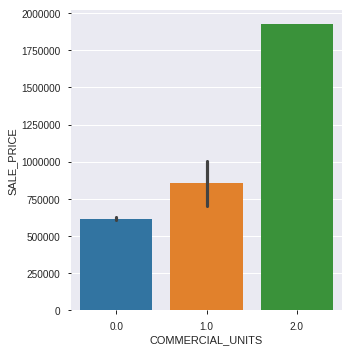

RESIDENTIAL_UNITS


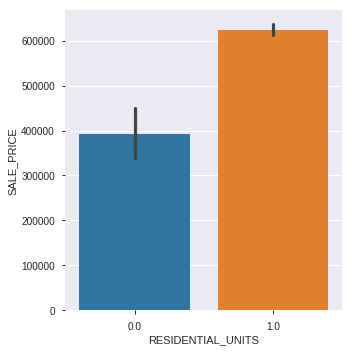

TAX_CLASS_AT_PRESENT


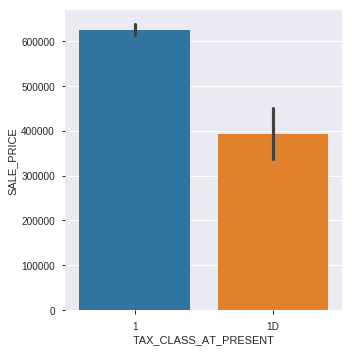

TAX_CLASS_AT_TIME_OF_SALE


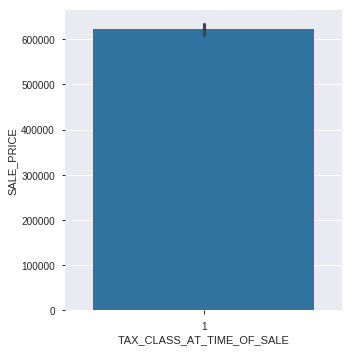

TOTAL_UNITS


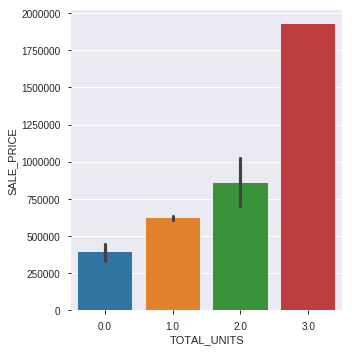

In [104]:
for col in sorted(train.columns):
  if df[col].nunique() < 15:
    print(col)
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar')
    plt.show();

In [105]:
## SIGNIFICANT LOOKING FEATURES
'''
TOTAL_UNITS
TAX_CLASS_AT_PRESENT
RESIDENTIAL UNITS
COMMERCIAL UNITS
BOUROUGH'''

'\nTOTAL_UNITS\nTAX_CLASS_AT_PRESENT\nRESIDENTIAL UNITS'

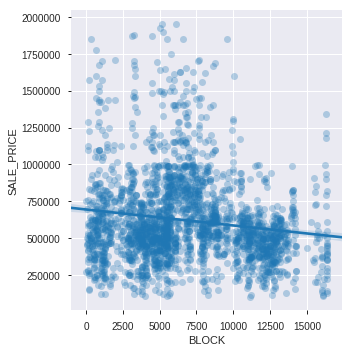

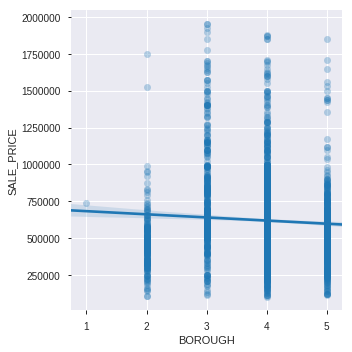

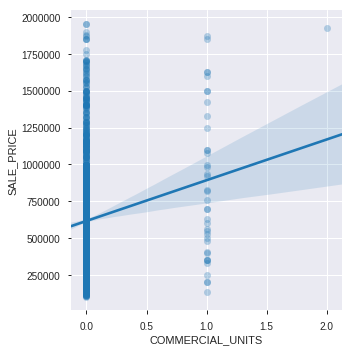

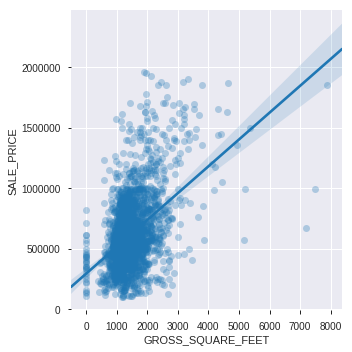

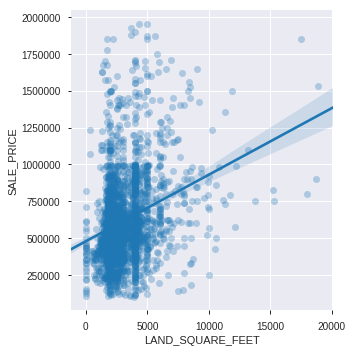

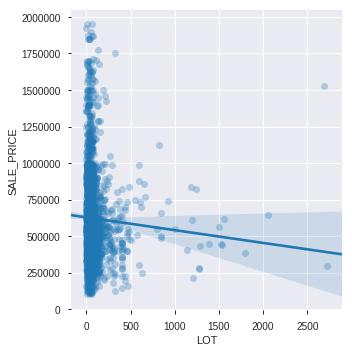

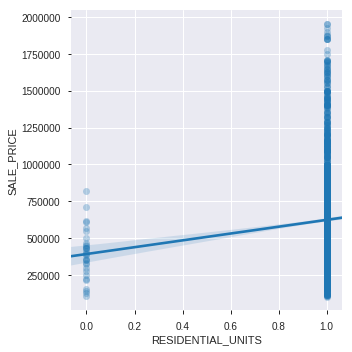

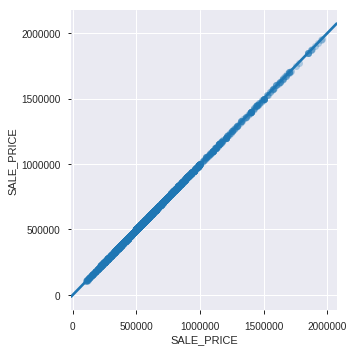

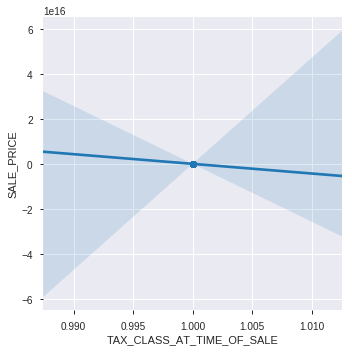

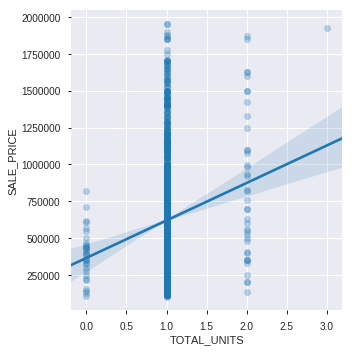

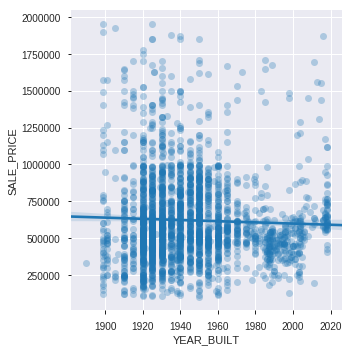

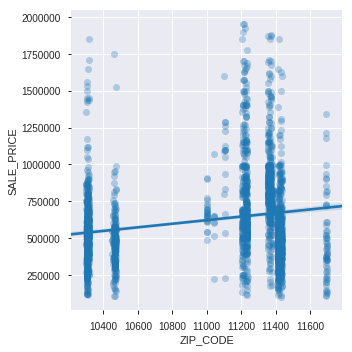

In [248]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.3))
  plt.show()

In [122]:
# SIGNIFICANT LOOKING FEATURES
'''
GROSS_SQUARE_FEET
RESIDENTIAL UNITS
TOTAL UNITS
COMMERCIAL UNITS
BLOCK (neg corr)'''

'\nGROSS_SQUARE_FEET\nRESIDENTIAL UNITS\nTOTAL UNITS'

In [130]:
# How many zip codes are there
train['ZIP_CODE'].nunique()

122

In [134]:
# Individual Boroughs
bronx = train[train['BOROUGH'] == 2]

bronx.shape

(242, 19)

In [249]:
# How does sale price vary over different zip codes
pd.set_option('precision', 0)
bronx.groupby('ZIP_CODE').SALE_PRICE.describe()


,count,mean,std,min,25%,50%,75%,max
ZIP_CODE,,,,,,,,
10452,5,494000,63581,395000,485000,490000,55000,6e+05
10453,1,465000,NaN,465000,465000,465000,46500,5e+05
10454,2,480000,395980,200000,340000,480000,62000,8e+05
10455,1,600000,NaN,600000,600000,600000,60000,6e+05
10456,1,182500,NaN,182500,182500,182500,18250,2e+05
10457,7,448933,113206,326864,363424,460000,48500,7e+05
10458,3,508333,150693,350000,437500,525000,58750,6e+05
10459,1,460000,NaN,460000,460000,460000,46000,5e+05
10460,3,551667,344976,350000,352500,355000,65250,1e+06


In [132]:
train.BOROUGH.value_counts()

4    1204
5     662
3     398
2     242
1       1
Name: BOROUGH, dtype: int64

# FEATURE ENGINEERING

In [346]:
# Boroughs are not ordinal, so their number encoding is useless
train['BOROUGH'] = train['BOROUGH'].replace({1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten Island'})
test['BOROUGH'] = test['BOROUGH'].replace({1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten Island'})
train['BOROUGH'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Queens           1993
Staten Island     983
Brooklyn          737
Bronx             349
Manhattan          32
Name: BOROUGH, dtype: int64

In [347]:
# Top 10 Neighborhoods, set the rest to Other
top_ten = train['NEIGHBORHOOD'].value_counts()[:10].index

train.loc[~train['NEIGHBORHOOD'].isin(top_ten), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top_ten), 'NEIGHBORHOOD'] = 'OTHER'
train['NEIGHBORHOOD'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


OTHER                       3150
FLUSHING-NORTH               147
GREAT KILLS                  105
QUEENS VILLAGE               104
SPRINGFIELD GARDENS           98
ST. ALBANS                    96
SO. JAMAICA-BAISLEY PARK      83
FLUSHING-SOUTH                81
SOUTH OZONE PARK              77
RICHMOND HILL                 77
BAYSIDE                       76
Name: NEIGHBORHOOD, dtype: int64

In [348]:
# How many unique values do the categorical variables have
# First 3 (after building class category) have reasonably few enough to encode
# Choosing BUILDING_CLASS_AT_TIME_OF_SALE rather than AT_PRESENT bec we want 
# to predict the sale price
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,4094,1,01 ONE FAMILY DWELLINGS,4094,NaN,NaN
TAX_CLASS_AT_PRESENT,4094,3,1,4058,NaN,NaN
BOROUGH,4094,5,Queens,1993,NaN,NaN
NEIGHBORHOOD,4094,11,OTHER,3150,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,4094,12,A1,1543,NaN,NaN
BUILDING_CLASS_AT_PRESENT,4094,15,A1,1542,NaN,NaN
SALE_DATE,4094,90,2019-03-29 00:00:00,96,2019-01-01 00:00:00,2019-03-31 00:00:00
LAND_SQUARE_FEET,4094,1280,"4,000",412,NaN,NaN
ADDRESS,4094,4059,277 NICHOLS AVENUE,3,NaN,NaN


In [0]:
import category_encoders as ce

In [349]:
# One Hot Encode 3 columns with fewest unique values
encoder = ce.OneHotEncoder(use_cat_names=True)
train_encoded = encoder.fit_transform(train[['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE']])
test_encoded = encoder.transform(test[['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE']])
train_encoded.head()

,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Queens,BOROUGH_Staten Island,BOROUGH_Manhattan,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_RICHMOND HILL,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_ST. ALBANS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,TAX_CLASS_AT_PRESENT_1B,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
42,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
44,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [254]:
# Verify same amount of rows as train
train_encoded.shape

(2507, 29)

In [255]:
# See above cell
train.shape

(2507, 19)

In [350]:
# Concat the original with the encoded data and drop the columns that are now
# one-hot encoded
train_encoded = pd.concat([train, train_encoded], axis=1).drop(['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'], axis=1)
test_encoded = pd.concat([test, test_encoded], axis=1).drop(['BOROUGH', 'BUILDING_CLASS_CATEGORY', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'], axis=1)

# Verify rows are the same and columns are total - dropped
train_encoded.shape, test_encoded.shape

((4094, 45), (967, 45))

In [0]:
# Split data
target = 'SALE_PRICE'
X_train = train_encoded.drop(target, axis=1)
y_train = train_encoded[target]
X_test = test_encoded.drop(target, axis=1)
y_test = test_encoded[target]

In [0]:
# Select only numeric columns
X_train_number = X_train.select_dtypes('number')
X_test_number = X_test.select_dtypes('number')

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error

In [353]:
# Create an instance of SelectKBest w K=10
selector = SelectKBest(score_func=f_regression, k=10)

# Fit and transform train and test data
X_train_selected = selector.fit_transform(X_train_number, y_train)
X_test_selected = selector.transform(X_test_number)

# Confirm 10 columns
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((4094, 10), (967, 10))

In [306]:
X_train_selected

array([[5.4950e+03, 1.1230e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.9180e+03, 1.1427e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.2100e+03, 1.0461e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.1320e+03, 1.0302e+04, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.3950e+03, 1.0305e+04, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.1159e+04, 1.1429e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [354]:
# First Model
# Linear Regression
model = LinearRegression()

# Fit the model
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Calculate Mean Absolute Error
mean_absolute_error(y_test, y_pred)

386941.55615898914

In [335]:
# Calculate R Squared score
r2_score(y_test, y_pred)

0.4102112189496814

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_number)
X_test_scaled = scaler.transform(X_test_number)

In [309]:
X_train_number.dtypes

BLOCK                                      int64
LOT                                        int64
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BOROUGH_Brooklyn                           int64
BOROUGH_Queens                             int64
BOROUGH_Bronx                              int64
BOROUGH_Staten Island                      int64
BOROUGH_Manhattan                          int64
NEIGHBORHOOD_OTHER                         int64
NEIGHBORHOOD_QUEENS VILLAGE                int64
NEIGHBORHOOD_BAYSIDE                       int64
NEIGHBORHOOD_FLUSHING-NORTH                int64
NEIGHBORHOOD_LAURELTON                     int64
NEIGHBORHOOD_SO. JAM

In [355]:
# Create an instance of SelectKBest w K=10
selector = SelectKBest(score_func=f_regression, k=10)

# Fit and transform train and test scaled data
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Confirm 10 columns
X_train_selected.shape, X_test_selected.shape

ValueError: ignored

In [276]:
# Second Model
# Linear Regression on scaled data
model = LinearRegression()

# Fit the model 
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Calculate Mean Absolute Error
mean_absolute_error(y_test, y_pred)

157233.5752953045

In [277]:
# No difference in scores with scaled vs non-scaled
r2_score(y_test, y_pred)

0.4102112189496868

In [283]:
X_test_number.shape

(644, 39)

In [356]:
for k in range(1, len(X_train_number)):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_number, y_train)
  X_test_selected = selector.transform(X_test_number)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print('Mean Absolute Error: ', mae)

1 features
Mean Absolute Error:  389408.8932476679
2 features
Mean Absolute Error:  388608.29377802426
3 features
Mean Absolute Error:  386884.9345296622
4 features
Mean Absolute Error:  387387.0266047415
5 features
Mean Absolute Error:  387412.29465851357
6 features
Mean Absolute Error:  386263.25918518385
7 features
Mean Absolute Error:  386074.55883690366
8 features
Mean Absolute Error:  386026.40503829904
9 features
Mean Absolute Error:  386987.28973639314
10 features
Mean Absolute Error:  386941.55615898914
11 features
Mean Absolute Error:  387000.76545511454
12 features
Mean Absolute Error:  387557.18379213306
13 features
Mean Absolute Error:  387690.3441704773
14 features
Mean Absolute Error:  388327.0736852549
15 features
Mean Absolute Error:  388327.0736852549
16 features
Mean Absolute Error:  389396.734183281
17 features
Mean Absolute Error:  389191.55118358356
18 features
Mean Absolute Error:  390588.49649724446
19 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Mean Absolute Error:  390633.4525113182
20 features
Mean Absolute Error:  390364.55550760264
21 features
Mean Absolute Error:  390849.7423111188
22 features
Mean Absolute Error:  390762.821720414
23 features
Mean Absolute Error:  390105.9325254494
24 features
Mean Absolute Error:  390105.9325254495
25 features
Mean Absolute Error:  390107.0319906854
26 features
Mean Absolute Error:  390091.66487623914
27 features
Mean Absolute Error:  390164.32367715787
28 features
Mean Absolute Error:  389950.95618567884
29 features
Mean Absolute Error:  389564.09410674707
30 features
Mean Absolute Error:  389647.8540024584
31 features
Mean Absolute Error:  389634.47308820864
32 features
Mean Absolute Error:  389634.47308820847
33 features
Mean Absolute Error:  389169.84401465545
34 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Mean Absolute Error:  389169.84401465603
35 features
Mean Absolute Error:  389169.84401465557
36 features
Mean Absolute Error:  388708.77495969424
37 features
Mean Absolute Error:  388708.77495969424
38 features
Mean Absolute Error:  388713.58768449543
39 features
Mean Absolute Error:  388713.587684496
40 features
Mean Absolute Error:  388713.5876844957
41 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

ValueError: ignored

In [366]:
import pandas as pd
import pandas_profiling
import category_encoders as ce

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

### CLEAN DATA

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# Drop Easement and Apartment number column bec theres too many NaNs
# Easement is entirely NaNs, and Apartment Number isnt very relevant for one family house
df = df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)

# Fill Year Built NaNs with mean year built
df.YEAR_BUILT.fillna(df.YEAR_BUILT.mean(), inplace=True)

# Filter dataframe to just One Family Dwellings
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

# Filter for just houses that sold between 100,000 - 2,000,000
df = df[(df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

# Clean out commas and conert to int
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '').astype(int)

# Drop rows with Land Square Feet of 0
df = df[df.LAND_SQUARE_FEET != 0]

# Convert Sale Date to datetime object
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Make cutoff date and split data on cutoff
cutoff = pd.to_datetime('2019-04-01')

# Split data into train and test
train = df[df['SALE_DATE'] < cutoff]
test =  df[df['SALE_DATE'] >= cutoff]

### FEATURE ENGINEERING

# Boroughs are not ordinal, so their number encoding is useless
train['BOROUGH'] = train['BOROUGH'].replace({1:'Manhattan', 2:'Bronx',
                                             3:'Brooklyn', 4:'Queens',
                                             5:'Staten Island'})
test['BOROUGH'] = test['BOROUGH'].replace({1:'Manhattan', 2:'Bronx',
                                           3:'Brooklyn', 4:'Queens',
                                           5:'Staten Island'})

# Top 10 Neighborhoods, set the rest to Other
top_ten = train['NEIGHBORHOOD'].value_counts()[:10].index

# Change all neighborhoods not in top ten to Other
train.loc[~train['NEIGHBORHOOD'].isin(top_ten), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top_ten), 'NEIGHBORHOOD'] = 'OTHER'

# One Hot Encode 3 columns with fewest unique values
encoder = ce.OneHotEncoder(use_cat_names=True)
train_encoded = encoder.fit_transform(train[['BOROUGH', 'NEIGHBORHOOD',
                                             'TAX_CLASS_AT_PRESENT',
                                             'BUILDING_CLASS_AT_TIME_OF_SALE']])
test_encoded = encoder.transform(test[['BOROUGH', 'NEIGHBORHOOD',
                                       'TAX_CLASS_AT_PRESENT',
                                       'BUILDING_CLASS_AT_TIME_OF_SALE']])

# Concat the original with the encoded data and drop the columns that are now
# one-hot encoded
train_encoded = pd.concat([train, train_encoded], axis=1).drop(['BOROUGH',
                                                                'BUILDING_CLASS_CATEGORY',
                                                                'NEIGHBORHOOD',
                                                                'TAX_CLASS_AT_PRESENT',
                                                                'BUILDING_CLASS_AT_TIME_OF_SALE',
                                                                'BUILDING_CLASS_AT_TIME_OF_SALE'],
                                                                 axis=1)
test_encoded = pd.concat([test, test_encoded], axis=1).drop(['BOROUGH',
                                                             'BUILDING_CLASS_CATEGORY',
                                                             'NEIGHBORHOOD',
                                                             'TAX_CLASS_AT_PRESENT',
                                                             'BUILDING_CLASS_AT_TIME_OF_SALE',
                                                             'BUILDING_CLASS_AT_TIME_OF_SALE'],
                                                              axis=1)

# Split both datasets into X matrix and Y vector
# Split data
target = 'SALE_PRICE'
X_train = train_encoded.drop(target, axis=1)
y_train = train_encoded[target]
X_test = test_encoded.drop(target, axis=1)
y_test = test_encoded[target]


# Select only numeric columns
X_train_number = X_train.select_dtypes('number')
X_test_number = X_test.select_dtypes('number')


# Create an instance of SelectKBest w K=10
selector = SelectKBest(score_func=f_regression, k=10)

# Fit and transform train and test data
X_train_selected = selector.fit_transform(X_train_number, y_train)
X_test_selected = selector.transform(X_test_number)

# Linear Regression
model = LinearRegression()

# Fit the model
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Calculate Mean Absolute Error
mean_absolute_error(y_test, y_pred)

# Calculate R_squared score
r2 = r2_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

157765.11291282804

In [359]:
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [360]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                    int64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object